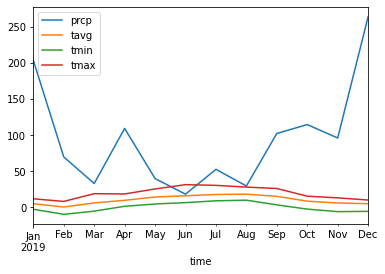

In [7]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2019, 1, 1)
end = datetime(2019, 12, 31)

# Create Point for Vancouver, BC
vancouver = Point(49.2497, -123.1193, 70)

# Get daily data for 2019
data = Daily(vancouver, start, end)
data = data.normalize()
data = data.aggregate('1M')
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['prcp', 'tavg', 'tmin', 'tmax'])
plt.show()

In [8]:
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2019-01-31,5.0,-2.7,11.8,203.5,NaN,147.9,11.9,NaN,1016.0,0.0
2019-02-28,0.4,-9.7,8.2,69.8,64.2,161.0,8.7,NaN,1011.7,0.0
2019-03-31,6.1,-5.3,18.9,33.0,NaN,174.4,8.5,NaN,1018.7,0.0
2019-04-30,9.7,1.4,18.5,109.3,NaN,175.4,13.1,NaN,1016.4,0.0
2019-05-31,14.3,4.6,25.4,39.8,NaN,209.1,9.6,NaN,1012.8,0.0


In [9]:
print(vancouver)

In [10]:
from meteostat import Stations

stations = Stations()
stations = stations.region('US')

print('Stations in US:', stations.count())

Stations in US: 2409


In [16]:
stations.fetch()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end
id,,,,,,,,,,,,,
69002,Hunter Ligget / Hunter-Liggett,US,CA,69002,KHGT,35.9935,-121.2367,310.0,America/Los_Angeles,1964-07-15,1997-04-01,1964-07-15,1971-07-31
69007,Fort Ord / Blanco,US,CA,69007,KOAR,36.6815,-121.7617,42.0,America/Los_Angeles,1973-01-02,2021-02-16,NaT,NaT
69014,Irvine,US,CA,69014,KNZJ,33.6667,-117.7167,119.0,America/Los_Angeles,1989-01-01,1999-06-06,1945-03-01,1998-12-10
69015,Twentynine Palms / Sunfair Heights,US,CA,69015,KNXP,34.2962,-116.1622,625.0,America/Los_Angeles,1990-01-02,2021-02-16,1945-05-01,2005-11-30
69019,Abilene / Tye,US,TX,69019,KDYS,32.4198,-99.8554,545.0,America/Chicago,1956-04-25,2021-02-16,1956-04-25,1970-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
PHJH0,Lahaina / Napili-Honokowai,US,HI,<NA>,PHJH,20.9629,-156.6730,78.0,Pacific/Honolulu,2006-01-01,2021-02-16,NaT,NaT
PHKO0,Kailua Kona / Mahaiula,US,HI,<NA>,PHKO,19.7388,-156.0456,14.0,Pacific/Honolulu,2006-01-01,2021-02-16,NaT,NaT
PHMU0,Kamuela / Puopelu,US,HI,<NA>,PHMU,20.0013,-155.6681,814.0,Pacific/Honolulu,1973-01-01,2021-02-16,NaT,NaT


# Build Weather DataFrame by State

In [54]:
import requests as req
import time
import os
import pandas as pd

api_key = os.environ["HIST_WEATHER_KEY"]

## Get the most delays in each state

In [62]:
%run ./db_connection.ipynb

In [67]:
select_top_cities = """
    SELECT 
    split_part(origin_city_name, ',', 1) AS city,
    split_part(origin_city_name, ',', 2) AS state,
    max(weather_delay)
    FROM flights
    WHERE date_part('year', TO_DATE(fl_date,'YYYY-MM-DD')) = 2019
    group by city, state

"""
flight_cities = execute_read_query(con, select_top_cities)
flight_cities.head()


,city,state,max
0,Aberdeen,SD,401.0
1,Abilene,TX,592.0
2,Adak Island,AK,15.0
3,Aguadilla,PR,19.0
4,Akron,OH,1847.0


In [68]:
flight_cities.shape

(365, 3)

In [70]:
flight_cities['state'].unique()

array([' SD', ' TX', ' AK', ' PR', ' OH', ' GA', ' NY', ' NM', ' LA',
       ' PA', ' MI', ' WI', ' CA', ' NC', ' WV', ' CO', ' NJ', ' MD',
       ' ME', ' IL', ' WA', ' MN', ' OR', ' MT', ' AL', ' ND', ' ID',
       ' MA', ' MO', ' TN', ' VT', ' WY', ' UT', ' IA', ' SC', ' VI',
       ' VA', ' MS', ' FL', ' NV', ' IN', ' AR', ' AZ', ' KS', ' NE',
       ' TT', ' CT', ' HI', ' OK', ' KY', ' NH', ' RI', ' DC'],
      dtype=object)

In [90]:
max_values = flight_cities[['state','max']].groupby('state').agg('max','max').reset_index()

In [95]:
city_max = pd.merge(max_values, flight_cities, 
                 how="inner",
                 left_on=['max', 'state'],
                 right_on=['max', 'state'])


In [96]:
city_max

,state,max,city
0,AK,701.0,Sitka
1,AL,1134.0,Dothan
2,AR,1234.0,Little Rock
3,AZ,1194.0,Tucson
4,CA,1570.0,San Luis Obispo
5,CO,1389.0,Aspen
6,CT,1440.0,Hartford
7,DC,1083.0,Washington
8,FL,1237.0,Fort Lauderdale
9,GA,1332.0,Savannah


## Call the Weather API for each City

In [48]:
url = "https://api.worldweatheronline.com/premium/v1/weather.ashx?"

In [49]:
# Method to call weather history for the location and date of each
# crash
def get_weather(url, date, cityname):
    #url = url + "q="+cityname+"&key="+api_key+"&date="+date+ "&fx=no&cc=no&mca=yes&format=json"
    
    res = req.get(url,params={
        'q':cityname,
        'date':'2019-01-01',
        'fx':'no',
        'cc':'no',
        'mca':'yes',
        'format':'json',
        'key':api_key})
        
        
    print(url)    
    print(res.status_code)
    return res.json()

In [119]:
date = "2019-01-01"
        
weather_dfs = []        
for city in city_max['city']:
    print("Calling for city", city)
    # call the method
    try:
    
        weather = get_weather(url, date, city)
        w_df = pd.json_normalize(
            weather['data']['ClimateAverages'], 
            record_path='month')
        w_df['city'] = city
        weather_dfs.append(w_df)        
        
    except:
        print("No weather found.")    


Calling for city Sitka
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Dothan
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Little Rock
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Tucson
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city San Luis Obispo
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Aspen
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Hartford
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Washington
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Fort Lauderdale
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Savannah
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Calling for city Kahului
https://api.worldweatheronline.com/premium/v1/weather.ashx?
200
Ca

,index,name,avgMinTemp,avgMinTemp_F,avgMaxTemp,avgMaxTemp_F,absMinTemp,absMinTemp_F,absMaxTemp,absMaxTemp_F,...,avgPressure_mb,avgPressure_inch,avgDryDays,avgRainDays,avgSnowDays,avgFogDays,avgThunderDays,avgUVIndex,avgSunHour,city
0,1,January,-2.3,27.9,2.8,37.1,-5.3,22.5,5.9096775,42.6,...,1017.8,30.5,21,7,4,1,0,2,217.8,New York
1,2,February,-1.5,29.3,4.2,39.6,-8.2,17.2,6.9260345,44.5,...,1017.2,30.5,18,7,4,2,1,2,209.3,New York
2,3,March,2.2,36.0,7.7,45.9,-0.4,31.3,11.4665165,52.6,...,1017.8,30.5,17,10,3,2,1,2,261.8,New York
3,4,April,7.2,45.0,13.2,55.8,5.6,42.1,16.393034,61.5,...,1015.4,30.5,17,11,0,2,2,3,295.8,New York
4,5,May,12.6,54.7,18.5,65.4,11.4,52.6,20.925774,69.7,...,1016.3,30.5,15,13,0,4,1,5,351.2,New York


In [120]:
len(weather_dfs)

53

In [121]:
#weather_dfs[0].columns
final_weather_df = pd.DataFrame(columns=weather_dfs[0].columns)
for df in weather_dfs:
    final_weather_df = final_weather_df.append(df, ignore_index=True)
final_weather_df.shape    

(636, 42)

In [122]:
final_weather_df[final_weather_df['name'] == 'January']

,index,name,avgMinTemp,avgMinTemp_F,avgMaxTemp,avgMaxTemp_F,absMinTemp,absMinTemp_F,absMaxTemp,absMaxTemp_F,...,avgPressure_mb,avgPressure_inch,avgDryDays,avgRainDays,avgSnowDays,avgFogDays,avgThunderDays,avgUVIndex,avgSunHour,city
0,1,January,-1.3,29.7,1.3,34.3,-8.9,15.9,4.3505163,39.8,...,1007.8,30.2,6,21,9,1,2,1,90.7,Sitka
12,1,January,5.8,42.4,14.8,58.6,1.8,35.2,18.840645,65.9,...,1021.2,30.6,21,9,0,5,1,3,259.3,Dothan
24,1,January,1.3,34.3,9.0,48.2,-1.9,28.6,11.461645,52.6,...,1021.5,30.6,20,8,1,4,1,3,219.9,Little Rock
36,1,January,6.6,43.9,16.8,62.2,3.8,38.8,19.308065,66.8,...,1018.3,30.5,28,3,0,0,1,4,295.7,Tucson
48,1,January,7.4,45.3,17.2,62.9,5.6,42.1,21.009903,69.8,...,1019.8,30.6,23,6,0,3,1,4,278.7,San Luis Obispo
60,1,January,-2.8,27.0,4.0,39.2,-6.4,20.4,7.2999997,45.1,...,1019.3,30.6,18,9,4,5,0,2,214.9,Aspen
72,1,January,-6.0,21.1,0.3,32.6,-10.3,13.5,4.419355,40.0,...,1016.7,30.5,18,9,8,5,0,1,203.2,Hartford
84,1,January,-2.4,27.7,4.6,40.2,-6.1,21.1,8.348387,47.0,...,1019.3,30.6,18,10,4,4,0,2,224.9,Washington
96,1,January,17.8,64.1,22.6,72.7,14.1,57.3,24.497162,76.1,...,1019.6,30.6,13,14,0,0,0,5,275.8,Fort Lauderdale
108,1,January,7.2,45.0,14.5,58.0,4.0,39.3,18.168581,64.7,...,1020.6,30.6,19,10,0,2,0,3,253.8,Savannah


In [124]:
final_weather_df = final_weather_df.drop(columns=['index'])
final_weather_df.head()

,name,avgMinTemp,avgMinTemp_F,avgMaxTemp,avgMaxTemp_F,absMinTemp,absMinTemp_F,absMaxTemp,absMaxTemp_F,avgTemp,...,avgPressure_mb,avgPressure_inch,avgDryDays,avgRainDays,avgSnowDays,avgFogDays,avgThunderDays,avgUVIndex,avgSunHour,city
0,January,-1.3,29.7,1.3,34.3,-8.9,15.9,4.3505163,39.8,0.5,...,1007.8,30.2,6,21,9,1,2,1,90.7,Sitka
1,February,-1.4,29.5,1.7,35.1,-4.4,24.1,4.371,39.9,0.6,...,1012.1,30.4,8,15,10,0,2,1,142.8,Sitka
2,March,-0.9,30.4,2.7,36.8,-3.9,24.9,5.7100325,42.3,1.3,...,1009.3,30.3,7,15,14,0,3,2,199.5,Sitka
3,April,1.9,35.4,5.6,42.1,-0.0,32.0,6.923333,44.5,4.4,...,1012.3,30.4,6,22,4,1,2,2,221.3,Sitka
4,May,5.4,41.8,9.6,49.3,3.4,38.0,12.629032,54.7,8.4,...,1015.8,30.5,9,20,0,4,0,3,298.0,Sitka


In [127]:
import calendar

d = dict((v,k) for k,v in enumerate(calendar.month_name))

In [130]:
final_weather_df['month'] = final_weather_df.name.map(d)
final_weather_df.head()

,name,avgMinTemp,avgMinTemp_F,avgMaxTemp,avgMaxTemp_F,absMinTemp,absMinTemp_F,absMaxTemp,absMaxTemp_F,avgTemp,...,avgPressure_inch,avgDryDays,avgRainDays,avgSnowDays,avgFogDays,avgThunderDays,avgUVIndex,avgSunHour,city,month
0,January,-1.3,29.7,1.3,34.3,-8.9,15.9,4.3505163,39.8,0.5,...,30.2,6,21,9,1,2,1,90.7,Sitka,1
1,February,-1.4,29.5,1.7,35.1,-4.4,24.1,4.371,39.9,0.6,...,30.4,8,15,10,0,2,1,142.8,Sitka,2
2,March,-0.9,30.4,2.7,36.8,-3.9,24.9,5.7100325,42.3,1.3,...,30.3,7,15,14,0,3,2,199.5,Sitka,3
3,April,1.9,35.4,5.6,42.1,-0.0,32.0,6.923333,44.5,4.4,...,30.4,6,22,4,1,2,2,221.3,Sitka,4
4,May,5.4,41.8,9.6,49.3,3.4,38.0,12.629032,54.7,8.4,...,30.5,9,20,0,4,0,3,298.0,Sitka,5


In [131]:
final_weather_df = final_weather_df.drop(columns=['name'])

In [132]:
city_state_map = dict(zip(city_max.city,city_max.state))
print(city_state_map)

{'Sitka': ' AK', 'Dothan': ' AL', 'Little Rock': ' AR', 'Tucson': ' AZ', 'San Luis Obispo': ' CA', 'Aspen': ' CO', 'Hartford': ' CT', 'Washington': ' DC', 'Fort Lauderdale': ' FL', 'Savannah': ' GA', 'Kahului': ' HI', 'Cedar Rapids/Iowa City': ' IA', 'Lewiston': ' ID', 'Chicago': ' IL', 'South Bend': ' IN', 'Wichita': ' KS', 'Louisville': ' KY', 'Baton Rouge': ' LA', 'Boston': ' MA', 'Baltimore': ' MD', 'Portland': ' OR', 'Grand Rapids': ' MI', 'Duluth': ' MN', 'Kansas City': ' MO', 'Jackson/Vicksburg': ' MS', 'Billings': ' MT', 'Charlotte': ' NC', 'Fargo': ' ND', 'Lincoln': ' NE', 'Manchester': ' NH', 'Newark': ' NJ', 'Albuquerque': ' NM', 'Las Vegas': ' NV', 'Rochester': ' NY', 'Akron': ' OH', 'Oklahoma City': ' OK', 'Philadelphia': ' PA', 'San Juan': ' PR', 'Providence': ' RI', 'Charleston': ' SC', 'Sioux Falls': ' SD', 'Memphis': ' TN', 'Pago Pago': ' TT', 'Lubbock': ' TX', 'Salt Lake City': ' UT', 'Norfolk': ' VA', 'Charlotte Amalie': ' VI', 'Burlington': ' VT', 'Pasco/Kennewick/R

In [134]:
final_weather_df['state'] = final_weather_df.city.map(city_state_map)
final_weather_df.head()

,avgMinTemp,avgMinTemp_F,avgMaxTemp,avgMaxTemp_F,absMinTemp,absMinTemp_F,absMaxTemp,absMaxTemp_F,avgTemp,avgTemp_F,...,avgDryDays,avgRainDays,avgSnowDays,avgFogDays,avgThunderDays,avgUVIndex,avgSunHour,city,month,state
0,-1.3,29.7,1.3,34.3,-8.9,15.9,4.3505163,39.8,0.5,32.8,...,6,21,9,1,2,1,90.7,Sitka,1,AK
1,-1.4,29.5,1.7,35.1,-4.4,24.1,4.371,39.9,0.6,33.1,...,8,15,10,0,2,1,142.8,Sitka,2,AK
2,-0.9,30.4,2.7,36.8,-3.9,24.9,5.7100325,42.3,1.3,34.4,...,7,15,14,0,3,2,199.5,Sitka,3,AK
3,1.9,35.4,5.6,42.1,-0.0,32.0,6.923333,44.5,4.4,39.9,...,6,22,4,1,2,2,221.3,Sitka,4,AK
4,5.4,41.8,9.6,49.3,3.4,38.0,12.629032,54.7,8.4,47.1,...,9,20,0,4,0,3,298.0,Sitka,5,AK


In [135]:
final_weather_df = final_weather_df.drop(columns=['city'])

In [136]:
final_weather_df.shape

(636, 41)

In [138]:
final_weather_df.columns

Index(['avgMinTemp', 'avgMinTemp_F', 'avgMaxTemp', 'avgMaxTemp_F',
       'absMinTemp', 'absMinTemp_F', 'absMaxTemp', 'absMaxTemp_F', 'avgTemp',
       'avgTemp_F', 'maxWindSpeed_kmph', 'maxWindSpeed_mph',
       'maxWindSpeed_knots', 'maxWindSpeed_ms', 'avgWindSpeed_kmph',
       'avgWindSpeed_mph', 'avgWindSpeed_knots', 'avgWindSpeed_ms',
       'avgWindGust_kmph', 'avgWindGust_mph', 'avgWindGust_knots',
       'avgWindGust_ms', 'avgDailyRainfall', 'avgDailyRainfall_inch',
       'avgMonthlyRainfall', 'avgMonthlyRainfall_inch', 'avgHumidity',
       'avgCloud', 'avgVis_km', 'avgVis_miles', 'avgPressure_mb',
       'avgPressure_inch', 'avgDryDays', 'avgRainDays', 'avgSnowDays',
       'avgFogDays', 'avgThunderDays', 'avgUVIndex', 'avgSunHour', 'month',
       'state'],
      dtype='object')

In [140]:
# 'avgDryDays','avgRainDays','avgCloud','avgSnowDays','avgThunderDays'
final_weather_df_1 = final_weather_df.drop(columns=['avgMinTemp', 'avgMinTemp_F', 'avgMaxTemp', 'avgMaxTemp_F','absMinTemp', 'absMinTemp_F', 'absMaxTemp', 'absMaxTemp_F', 'avgTemp','avgTemp_F', 'maxWindSpeed_kmph', 'maxWindSpeed_mph','maxWindSpeed_knots', 'maxWindSpeed_ms', 'avgWindSpeed_kmph',
'avgWindSpeed_mph', 'avgWindSpeed_knots', 'avgWindSpeed_ms','avgWindGust_kmph', 'avgWindGust_mph', 'avgWindGust_knots','avgWindGust_ms', 'avgDailyRainfall', 'avgDailyRainfall_inch',
'avgMonthlyRainfall', 'avgMonthlyRainfall_inch', 'avgHumidity',
'avgVis_km', 'avgVis_miles', 'avgPressure_mb',
'avgPressure_inch','avgFogDays','avgUVIndex','avgSunHour'])

In [141]:
final_weather_df_1.head()

,avgCloud,avgDryDays,avgRainDays,avgSnowDays,avgThunderDays,month,state
0,71.88902,6,21,9,2,1,AK
1,59.98634,8,15,10,2,2,AK
2,63.13468,7,15,14,3,3,AK
3,65.64491,6,22,4,2,4,AK
4,59.64408,9,20,0,0,5,AK


## Save the Weather to a Pickle file

In [142]:
import pickle
outfile = open('./reference/weather_by_month','wb')

pickle.dump(final_weather_df_1,outfile)
outfile.close()   

XGB

Naive Bayes
Random Forest

